# Understanding the SHAP interpretation method: Kernel SHAP


In the [last blog article](https://data4thought.com/shap.html) I've introduced the SHAP machine learning interpretation method, and presented its main underlying concept: Shapley values. 

We've seen that Shapley values, despite being very satisfying when used as feature weights for the means interpretation, are not practical.

The computation of Shapley values is only tractable in low-dimensional problems. This is why the [SHAP paper](<http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions>) introduces methods to compute approximate Shapley values, without having to train this huge number of models.

The most versatile such method is called Kernel SHAP and is the topic of this blog post. 

## SHAP or the art of tractable estimations of Shapley values

Several methods have been proposed to estimate Shapley values efficiently. The main problem is to estimate the models fit with subsets of features, and avoid computing terms for all possible coalitions. Some proposed methods are model-specific (to linear models, [tree-based models](https://arxiv.org/abs/1802.03888) and [neural networks](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf)) and another one is generic but might be slower or provide worse estimations ([Kernel SHAP](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf)).

I will only go through KernelSHAP because it is the most versatile version of SHAP. The interested reader can go through the references above.

The core idea of Kernel SHAP is the following: instead of retraining models with subsets of features, we can use the full model $f$ that is already trained, and replace "missing features" with "marginalized features" (i.e. missing features are "integrated out"), that are typically estimated with data samples. For instance with 3 features $x_1$, $x_2$, and $x_3$\, the partial models where $x_3$ is missing is estimated with the following formula:

$$ f_{\left\{x_1, x_2\right\}}\left(x_1, x_2\right) \xrightarrow[\text{Kernel SHAP}]{} \int f\left(x_1, x_2, x_3\right)  p(x_3) \mathrm d x_3$$

Estimating this quantity still requires a choice for $p(x_3)$. A naive sampling choice would lead to the use of unrealistic data points and would break the desired explanations properties mentioned above. 

The authors found a way to maintain those properties with the LIME method. Note that is doesn't mean that we have done all this work and ended up using plain LIME. Here LIME is used with a custom proximity function $\pi$ that is very different from LIME's:

$$ \pi_x^{\mathrm{LIME}}(z) = \exp (−D(x, z)^2/\sigma^2), $$ 

where $D$ is a distance function (typically the cartesian distance for structured data), 

$$ \pi_{x}^{\mathrm{SHAP}}\left(z^{\prime}\right)=\frac{(p-1)}{\left(\begin{array}{c}{p} \\ {\left|z^{\prime}\right|}\end{array}\right)\left|z^{\prime}\right|\left(p-\left|z^{\prime}\right|\right)},$$

where $p$ is the number of features.

These two equations are obviously very different, the first one uses the original features (masked, hence $z$ instead of $x$) and penalizes distances between sampled points and the original data point for which we seek an explanation. On the other hand, the SHAP similarity kernel only uses the **number** of features in the coalition $|z'|$ and it penalizes coalitions with a number of features that are far from $0$ or $p$. That is, it puts more weight on coalitions that are either using a small number of features (because it highlights the "independent" behavior of the features) or almost all of them (because it highlights the impact of features in interaction with all of the others). The theory behind this choice of the kernel is that it is the one that guarantees three desirable properties of additive feature attributions methods mentioned above (Theorem 2 of the paper). 

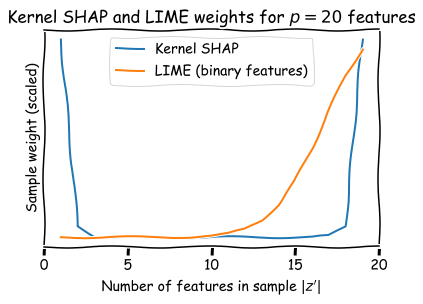

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.special import binom
plt.xkcd()

def shap_kernel(z, p):
    """ Kernel SHAP weights for z unmasked features among p"""
    return (p-1)/(binom(p, z)*(z*(p-z)))

def lime_kernel(z, p):
    """LIME kernel for binary input features """
    return np.exp(-(z-p)**2/p)
    
n_features = 20

x = list(range(1, n_features))
scaling_factor = shap_kernel(1, n_features)
plt.plot(x, [shap_kernel(z, n_features)/scaling_factor for z in x], label="Kernel SHAP")
plt.plot(x, [lime_kernel(z, n_features) for z in x], label="LIME (binary features)")
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([])
plt.title(f"Kernel SHAP and LIME weights for $p={n_features}$ features")
plt.xlabel("Number of features in sample $\\left|z^{\\prime}\\right|$")
plt.ylabel("Sample weight (scaled)")
plt.legend()
plt.show();

So, as expected the biggest difference between the Kernel SHAP and the LIME sample weighting strategies is seen when only a few features are present: LIME attributes a small weight to those samples because they are far from the datapoint being investigated, while Kernel SHAP attributes a large weight to it because it isolates the individual behavior of features.

Note that the weights for $\left|z^\prime\right|=0$ and $\left|z^\prime\right|=p$ are not represented because they are infinite! Those infinities ensure missingness ($z_i = 0 \Longrightarrow \phi_i = 0$, so $\phi_0 = f(\emptyset)$) and local accuracy ($\sum_i \phi_i = f(x)$) respectively. In practice, "[...] these infinite weights can be avoided during optimization by analytically eliminating two variables using these constraints." (the constraints being the missingness and local accuracy equations).

## Toy examples

In the following of this post I'll simply reproduce the computation SHAP attributions step-by-step on toy examples, starting with the one-dimensional case and moving on to the two-dimensional one.

## One dimension

The one-dimensional case is trivial: as mentioned above the infinite weights for coalitions involving no features or all of them impose two constraints:

$$\phi_0 = f(\emptyset)$$
and
$$\sum_i \phi_i = \phi_0 + \phi_1 = f(x)$$

We can estimate $\phi_0$ as the average prediction of the model over all samples, such that the weight of the only variable is the difference of the model prediction and the average prediction: $\phi_1 = f(x) - \frac1N\sum_j f\left(x_j\right)$. 

Thus for a very simple model that predicts 0 for $x<0$ and 1 otherwise, the weight $\phi_1$  of the only feature is -0.5 for every data point below 0 and +0.5 above 0.

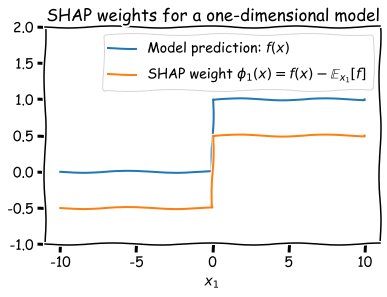

In [4]:
x = np.arange(-10, 10, 0.01)
predictions = [float(i > 0) for i in x]
plt.plot(x, predictions, label="Model prediction: $f(x)$")
plt.plot(x, [f-0.5 for f in predictions], label="SHAP weight $\phi_1(x)=f(x)-\mathbb{E}_{x_1}[f]$")
plt.ylim(-1, 2)
plt.title(f"SHAP weights for a one-dimensional model")
plt.xlabel("$x_1$")
plt.legend();

## Two dimensions

With two features we actually have to sample data points to estimate Shapley values with Kernel SHAP. As before the reference Shapley value $\phi_0$ is given by the average of the model over the dataset, and the infinite sample weight for the features coalition involving all features ($\pi_{x}^{\mathrm{SHAP}}\left(p\right)=\infty$) imposes the constraint mentioned above: $\phi_0 + \phi_1 + \phi_2 = f(x)$.

## Toy dataset creation
Let's create a "disk-shaped" dataset.

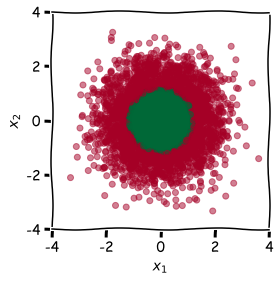

In [7]:
from sklearn.datasets import make_gaussian_quantiles

dataset = make_gaussian_quantiles(n_samples=5000, n_classes=2, random_state=2020)

x, y = dataset[0], 1-dataset[1]

plt.scatter(x[:, 0], x[:, 1], c=y, alpha=0.5, cmap="RdYlGn")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect(aspect=1.)

## Fit a model

Here I fit a small neural network since a linear model would of course not be able to reproduce the decision boundaries of our disk dataset. Note that an SVM would have been the best choice (or a linear model on smartly transformed features, e.g. $x_1 \rightarrow x_1^2+x_2^2$).

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
np.random.seed(2020)
tf.random.set_seed(2020)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2020)


def create_model():
    """ Model creation function: returns a compiled MLP"""
    model = Sequential()
    model.add(Dense(10, activation='tanh', name="hidden", input_dim=2))
    model.add(Dense(1, activation='sigmoid', name="output"))
    model.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])
    return model

neural_net = KerasClassifier(build_fn=create_model, epochs=100, batch_size=64, verbose=0)

neural_net.fit(x_train, y_train)

print(f"Accuracy: {neural_net.score(x_test, y_test):.3f}")

Accuracy: 0.980


## Plot the decision boundary

Model score for the prediction to be explained: f(1.3, 0.0)=0.233


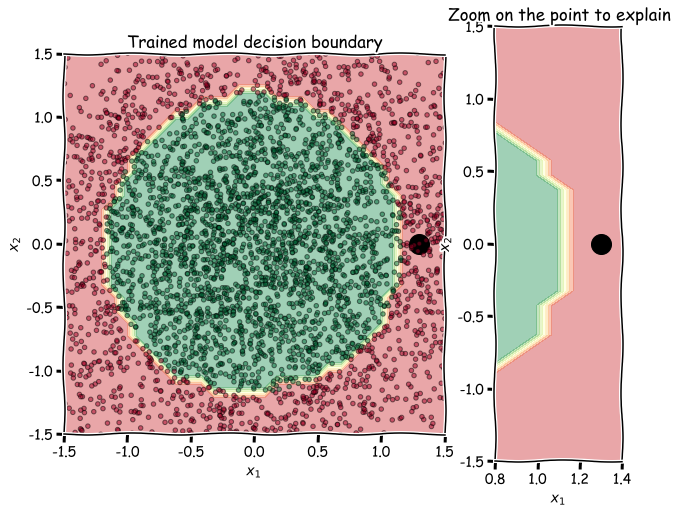

In [9]:
x_explain = (1.3, 0.)

x_explain_prediction = neural_net.predict_proba(np.array([x_explain]))[:, 1][0]
print(f"Model score for the prediction to be explained: f{x_explain}={x_explain_prediction:.3f}")
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, figsize=(10, 8), gridspec_kw={'width_ratios': [3, 1]})

Z = neural_net.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

for ax in axarr:
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdYlGn")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.scatter([x_explain[0]], [x_explain[1]], c="black", s=400)
    
axarr[0].scatter(x[:, 0], x[:, 1], c=y, s=20, alpha = 0.5, edgecolor='k', cmap="RdYlGn")
axarr[0].set_title("Trained model decision boundary")
axarr[0].set_xlim(-1.5, 1.5)
axarr[0].set_ylim(-1.5, 1.5)
axarr[0].set_aspect(aspect=1.)

axarr[1].set_title("Zoom on the point to explain")
axarr[1].set_xlim(0.8, 1.4)
axarr[1].set_ylim(-1.5, 1.5)
plt.show()

## SHAP samples

At this point a crucial assumption is made in the SHAP paper: feature independence. This assumption corresponds to the step from equation (10) to equation (11) in the paper 
$$E_{z_{\bar{S}} | z_{S}}[f(z)] \approx E_{z_{\bar{S}}}[f(z)],$$ 

and is equivalent to assuming that the impact of adding a variable to a coalition is always the same not matter what is the initial coalition.

This assumption greatly simplifies the problem because it gives a recipe for the computation of the model prediction with missing values. In our 2-dimensional problem we simply have to compute the average prediction of the model with one fixed and the other one varying over the samples, and do the same for the other variable:

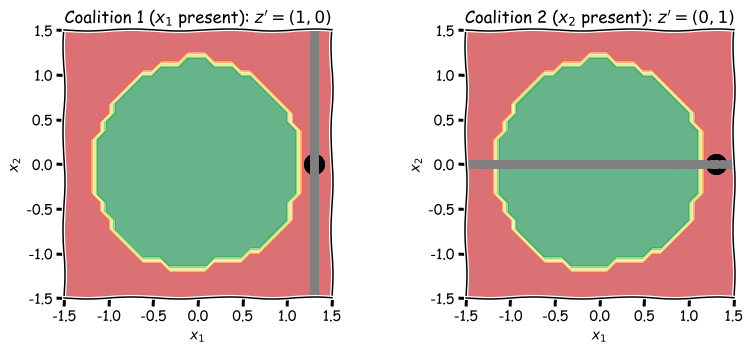

In [10]:
np.random.seed(2020)
n_samples = 1000

x1_present = np.column_stack((np.full(n_samples, x_explain[0]), np.random.randn(n_samples)))
x2_present = np.column_stack((np.random.randn(n_samples), np.full(n_samples, x_explain[1])))
shap_samples = np.concatenate((x1_present, x2_present))

f, axarr = plt.subplots(1, 2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.5)

for i, ax in enumerate(axarr):
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdYlGn")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.scatter([x_explain[0]], [x_explain[1]], c="black", s=400)
    
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdYlGn")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.scatter([x_explain[0]], [x_explain[1]], c="black", s=400)
    if i == 0:
        ax.scatter([x_explain[0]]*len(shap_samples[:, 1]), [shap_samples[:, 1]], c="grey", alpha=1., s=50)
        ax.set_title("Coalition 1 ($x_1$ present): $z^\prime=(1, 0)$")
    else:
        ax.scatter([shap_samples[:, 0]], [x_explain[1]]*len(shap_samples[:, 0]), c="grey", alpha=1., s=50)
        ax.set_title("Coalition 2 ($x_2$ present): $z^\prime=(0, 1)$")

    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect(1.)
    
plt.show()

Remember that we only have to determine one Shapley value, the other two being fully determined by the $\pi_{x}^{\mathrm{SHAP}}\left(0\right)=\infty$ and $\pi_{x}^{\mathrm{SHAP}}\left(p\right)=\infty$ constraints.

In [11]:
f_x1_present = neural_net.predict_proba(x1_present)[:, 1]
print(f"Average model prediction with only $x_1$ fixed (to 1.3): f(1.3, .)={f_x1_present.mean():.3f}")
f_x2_present = neural_net.predict_proba(x2_present)[:, 1]
print(f"Average model prediction with only $x_2$ fixed (to 0): f(., 0)={f_x2_present.mean():.3f}")

Average model prediction with only $x_1$ fixed (to 1.3): f(1.3, .)=0.139
Average model prediction with only $x_2$ fixed (to 0): f(., 0)=0.764


Going back to SHAP sample figure, the first value is the average of the model prediction over the vertical line, and the second value is the same average over the horizontal line.

In our 2-dimensional example, we're simply trying to find $\phi_1$ and $\phi_2$ such that we minimize the *fidelity function*

$$ \begin{align}
L\left(f, g, \pi_{x}\right)&=\sum_{z^{\prime} \in Z}\left[f\left(h_{x}\left(z^{\prime}\right)\right)-g\left(z^{\prime}\right)\right]^{2} \pi_{x}\left(z^{\prime}\right)\\
            &= \frac12 \left [ \mathbb E_{z_2} f(x_1, z_2) - (\phi_0 + \phi_1)\right]^2 + \frac12 \left [ \mathbb E_{z_1} f(z_1, x_2) - (\phi_0 + \phi_2)\right]^2
\end{align}.$$


We can rewrite this using the missingness constraint 
$$\mathbb{E} [f] = \phi_0$$

and the local accuracy one
$$f(x)=\sum\phi_i \Longleftrightarrow \phi_2=f(x)-\phi_0-\phi_1, $$
such that the fidelity reads:
$$ L\left(f, g, \pi_{x}\right) = \frac12 \left [ \left(\mathbb E_{z_2} f(x_1, z_2) - \mathbb E [f]\right) - \phi_1\right]^2 + \frac12 \left [ \left(\mathbb E_{z_1} f(z_1, x_2) - f(x) \right)+ \phi_1 \right]^2
.$$

Thus, we have to solve a linear regression problem with
$$ X = \begin{pmatrix}
1 \\
-1
\end{pmatrix} \qquad 
y= \begin{pmatrix}
\mathbb E_{z_2} f(x_1, z_2) - \mathbb{E} [f]\\
\mathbb E_{z_1} f(z_1, x_2) - f(x)
\end{pmatrix}, $$

i.e. a one-dimensional linear regression with two-samples! Piece of 🎂.

In [12]:
from sklearn.linear_model import LinearRegression

non_zero_z = np.array([1., 1.])  # Number of non-zero elements
sample_weights = shap_kernel(non_zero_z, 2)
phi0 = neural_net.predict_proba(x_train)[:, 1].mean()


X_shap = np.array([[1.], [-1.]])
y_shap = np.array([[f_x1_present.mean()-phi0], [f_x2_present.mean()-x_explain_prediction]])

solver = LinearRegression(fit_intercept=False)
solver.fit(X_shap, y_shap, sample_weight=sample_weights)
phi1 = solver.coef_[0][0]
phi2 = x_explain_prediction - phi0 - phi1
print(f"Results: \n\tphi0={phi0:.3f}, \n\tphi1={phi1:.3f}, \n\tphi2={phi2:.3f}")

Results: 
	phi0=0.511, 
	phi1=-0.452, 
	phi2=0.173


The interpretation of those results is the following: 
- The average of the model over the training set is 0.511
- The first feature $x_1$ has a weight close to -0.452, meaning that for similar examples with different values of $x_1$, the prediction of the model is much larger
- The second feature $x_2$ has a weight that is positive, such that this value is positively correlated with the prediction of the model for similar instances. 

Note that fitting $\phi_2$ instead of $\phi_1$ gives similar results, as expected.

## Using the SHAP package

In [17]:
import pandas as pd
from shap import KernelExplainer, initjs, force_plot

initjs()

sample = pd.DataFrame({"$x_1$": [x_explain[0]], "$x_2$": [x_explain[1]]})
labeled_x = pd.DataFrame(x, columns=["$x_1$", "$x_2$"])
explainer = KernelExplainer(neural_net.predict_proba, labeled_x.iloc[:50])

phi0 = explainer.expected_value[1]
print(f"Model average: $\phi_0={phi0:.3f}$")
shap_values = explainer.shap_values(sample, nsamples=10000, l1_reg=0., silent=True)[1]
print(f"Shapley values: $\phi_1={shap_values[0][0]:.3f}$, $\phi_2={shap_values[0][1]:.3f}$")

check = phi0 + sum(shap_values[0]) - x_explain_prediction
print(f"Sanity check (should be close to 0): $\sum_i \phi_i - f(x) = {check}$")
force_plot(phi0, shap_values[0,:], sample)

Model average: $\phi_0=0.519$
Shapley values: $\phi_1=-0.449$, $\phi_2=0.162$
Sanity check (should be close to 0): $\sum_i \phi_i - f(x) = 0.0$


The results are almost identical to ours, the small difference possibly being due to the different solver (hand-written normal equations for SHAP), and a slightly different evaluation of the model average predictions. (see [the code on GitHub](https://github.com/slundberg/shap/blob/73591d9a4d378284426bbfb89ef5e2092d2c9327/shap/explainers/kernel.py#L604) for details about the implementation).

## Conclusion

We've presented the machine learning model interpretation problem on a toy example, highlighted the shortcomings of a naive approach, the improvements of using Shapley values... and the unfortunate intractability. 

The SHAP paper introduces a set of three desirable properties of feature attribute methods plus several techniques to efficiently estimate feature attributions. I've focused on KernelSHAP here because it is the most versatile of those methods, but DeepSHAP and TreeSHAP are even better for the eponym models, the first one being more efficient and the second one being exact and fast!

Note that the two-dimensional version of KernelSHAP that we have derived is easily generalized to larger dimensions: one simply has to write the fidelity function 

$$L\left(f, g, \pi_{x}\right)=\sum_{z^{\prime} \in Z}\left[f\left(h_{x}\left(z^{\prime}\right)\right)-g\left(z^{\prime}\right)\right]^{2} \pi_{x}\left(z^{\prime}\right)$$

for all coalitions $z^\prime$ and replace $\phi_0$ with the average of $f$, and $\phi_p$ with $f(x)-\sum_{i=0}^{p-1}\phi_i$. It results in a $p-1$-dimensional linear regression problem with a number of examples that is equal to the number of possible coalitions $p!$.

I hope SHAP is a bit less mysterious now, do not hesitate to play with the package and the various visualizations it offers. You can also compare it with other equivalent methods (LIME, Integrated gradients, ...) to make your own mind regarding the relevance of the method. I personally like the fact that the authors provide a set of desirable properties and build methods with those constraints in mind. Let me know what you think in the comments!